In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


df = pd.read_csv("/Users/samuelescarfone/Desktop/Dat 300/project1/Predicting-Credit-Card-Defaults/data/Loan_default.csv", header=0)
df.head(5)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


# Cleaning & Preparing the Data

#### Convert Text Values into Integers

In [2357]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df:
    if df[col].dtype =='object':
        df[col] = encoder.fit_transform(df[col])

In [2358]:
target = 'Default'
print(df.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


#### Remove Non-Categorical Data and Columns Highly Uncorrelated With Target

Unique values per column:
LoanID            255347
LoanAmount        158729
Income            114620
InterestRate        2301
CreditScore          550
MonthsEmployed       120
DTIRatio              81
Age                   52
LoanTerm               5
LoanPurpose            5
NumCreditLines         4
Education              4
EmploymentType         4
MaritalStatus          3
HasMortgage            2
HasDependents          2
HasCoSigner            2
Default                2
dtype: int64


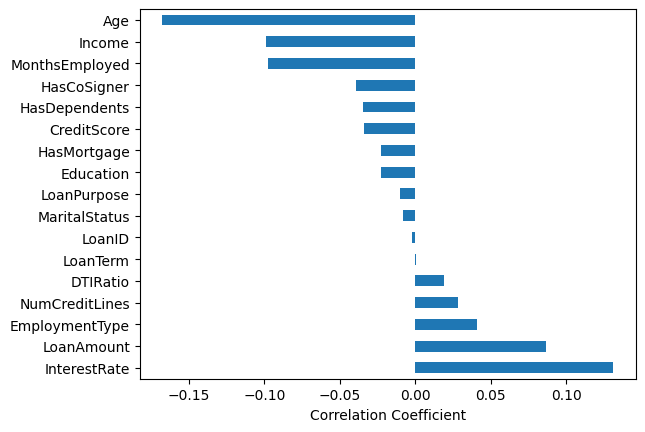

In [2359]:
corr = df.corr(numeric_only=True)
corr.head(10)
corr_with_default = corr['Default'].sort_values(ascending=False)

uniqueRows = df.nunique().sort_values(ascending=False)
print("Unique values per column:")
print(uniqueRows)

#Barplot
corr_with_default.drop('Default').plot(kind='barh')
plt.xlabel('Correlation Coefficient')
plt.show() 



In [2360]:
df = df.drop(columns=['LoanID','InterestRate','LoanTerm','LoanAmount','Income' ,'MonthsEmployed', 'DTIRatio','Age','CreditScore' ])
df.dropna(inplace=True)

In [2361]:
df.head(5)

,NumCreditLines,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,4,0,0,0,1,1,4,1,0
1,1,2,0,1,0,0,4,1,0
2,3,2,3,0,1,1,0,0,1
3,3,1,0,1,0,0,1,0,0
4,4,0,3,0,0,1,0,0,0


In [2362]:
df[target].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [2363]:
df.describe()

,NumCreditLines,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,2.501036,1.494421,1.500096,0.999918,0.500014,0.500268,2.000501,0.500108,0.116128
std,1.117018,1.118826,1.117358,0.816051,0.500001,0.500001,1.412723,0.500001,0.320379
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,0.000000
max,4.000000,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


# Native Bayes Model

- Randomize Data and Split into Train and Test Sets

In [2364]:
np.random.seed(1234)
randomize_data = df.sample(frac=1) 
train_size = int(0.8 * len(randomize_data))
training = randomize_data[:train_size].reset_index(drop=True)
testing = randomize_data[train_size:].reset_index(drop=True)
print("Training shape:", training.shape)
print("Testing size:", testing.shape)


Training shape: (204277, 9)
Testing size: (51070, 9)


In [2365]:
training[target].value_counts(normalize=True)

Default
0    0.88355
1    0.11645
Name: proportion, dtype: float64

In [2366]:
testing[target].value_counts(normalize=True)

Default
0    0.885158
1    0.114842
Name: proportion, dtype: float64

In [2367]:
trainX = training.iloc[:, :-1]
trainX = training.drop(columns=[target])

trainY = training[target]
colnames = trainX.columns

trainX.head(5)


,NumCreditLines,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,4,2,1,2,1,1,1,0
1,2,0,2,0,0,1,1,0
2,4,1,0,2,1,1,3,1
3,2,2,2,1,0,0,1,0
4,1,0,2,0,0,1,1,1


In [2368]:
testX = testing.iloc[:, :-1]
testX = testing.drop(columns=[target])

testY = testing[target]


In [2369]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)

trainBrnli[:5]

array([0, 0, 0, 1, 0])

#### Run Model on Training Data

In [2370]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)  
trainX = pd.DataFrame(trainX, columns=colnames)

trainX.head() 

,NumCreditLines,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
1,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0
2,3.0,1.0,0.0,2.0,1.0,1.0,3.0,1.0
3,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0


In [2371]:
model = MultinomialNB()  #create model object
model.fit(trainX,trainBrnli) 

MultinomialNB()

In [2372]:
yhattrain = model.predict(trainX)

In [2373]:
pd.crosstab(yhattrain, trainY)

Default,0,1
row_0,,
0,180489,23788


In [2374]:
print("Accuracy: ", str(accuracy_score(yhattrain, trainBrnli)*100) + "%")

Accuracy:  88.3550277319522%


### Model Performance on Test Data

In [2375]:
print("testX shape:", testX.shape)
print("trainX shape:", trainX.shape)

testX shape: (51070, 8)
trainX shape: (204277, 8)


In [2376]:
testBrnli = le.fit_transform(testY)

testX = enc.fit_transform(testX) 
testX = pd.DataFrame(testX, columns=colnames) 
testX = pd.DataFrame(testX, columns=colnames) 
yhattest = model.predict(testX)
yhattest[:9] 


array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [2377]:
acc = accuracy_score(yhattest, testBrnli)
print("Accuracy: "+str(acc*100)+"%")

Accuracy: 88.51576267867632%


In [2378]:
confM = confusion_matrix(yhattest, testBrnli)
print('Confusion matrix\n', confM)
print('True Positives = ', confM[0,0])
print('True Negatives = ', confM[1,1])
print('False Positives = ', confM[0,1])
print('False Negatives = ', confM[1,0])

Confusion matrix
 [[45205  5865]
 [    0     0]]
True Positives =  45205
True Negatives =  0
False Positives =  5865
False Negatives =  0


In [2379]:
pd.crosstab(yhattest, testY)
FNR  = confM[0,1] /(confM[1,1]+confM[0,1])
print(FNR)

1.0


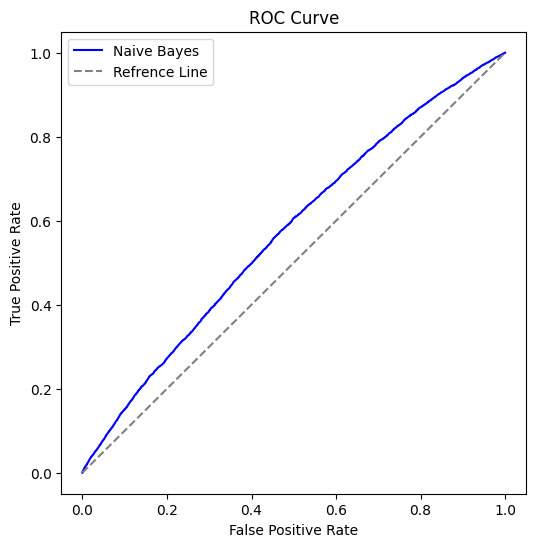

In [2380]:
from sklearn.metrics import roc_curve

yProb = model.predict_proba(testX)[:,1]
f,t,thresh = roc_curve(testBrnli, yProb)

plt.figure(figsize=(6,6))
plt.plot(f,t,color='blue',label='Naive Bayes')
plt.plot([0,1],[0,1],color='gray', linestyle='--', label='Refrence Line')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

